In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

import tensorflow as tf
import autokeras as ak

In [7]:
#load data
from BIAS.SB_Test_runner import get_scens_per_dim, get_simulated_data

rep = 6000
n_samples = 100

scenes = get_scens_per_dim()
X = []
y = []
for scene in scenes:
    label = scene[0]
    kwargs = scene[1]
    if (label == "unif"):
        rep1 = 5 * rep
    elif (label in ["trunc_unif", "cauchy", "norm"]):
        rep1 = int(rep / 3)
    elif (label in ["bound_thing","inv_norm", "inv_cauchy"]):
        rep1 = int(rep / 3)
    elif (label in ["clusters"]):
        rep1 = rep
    elif (label in ["gaps", "part_unif"]):
        rep1 = int(rep / 2)
    elif (label in ["spikes", "shifted_spikes"]):
        rep1 = int(rep / 2)
    data = get_simulated_data(label, rep=rep1, n_samples = n_samples, kwargs=kwargs)
    for r in range(rep1):
        X.append(np.sort(data[:,r]))
    if (label in ["trunc_unif", "cauchy", "norm"]):
        label = "centre"
    elif (label in ["bound_thing","inv_norm", "inv_cauchy"]):
        label = "bounds"
    elif (label in ["clusters"]):
        label = "cluster"
    elif (label in ["gaps", "part_unif"]):
        label = "gap"
    elif (label in ["spikes", "shifted_spikes"]):
        label = "disc"
    y.extend([label]*rep1)

X = np.array(X)
int_y, targetnames= pd.factorize(y)

cat_y = to_categorical(int_y)

TypeError: 'float' object cannot be interpreted as an integer

In [5]:

print(X.shape)
print(int_y.shape)
print(cat_y.shape)

print(targetnames)

print(y[0])
print(int_y[0])
print(cat_y[0])


(148000, 100)
(148000,)
(148000, 6)
['unif' 'centre' 'disc' 'bounds' 'gap' 'cluster']
unif
0
[1. 0. 0. 0. 0. 0.]


In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, cat_y, test_size=0.2, random_state=42, stratify=int_y)

clf = ak.StructuredDataClassifier(
    max_trials=20,
    overwrite=True,
)
# Search for the best model with EarlyStopping.
cbs = [
    tf.keras.callbacks.EarlyStopping(patience=5),
]

clf.fit(
    x=X_train,
    y=y_train,
    epochs=40,
    callbacks=cbs,
)
# Evaluate on the testing data.
print(
    "Accuracy: {accuracy}".format(
        accuracy=clf.evaluate(x=X_test, y=y_test)
    )
)

#interesting option from autokeras.image.image_supervised import ImageClassifier1D
#model = ImageClassifier1D(verbose=True)

#X_train = np.expand_dims(X, axis=2)
#model.fit(X_train, Y, time_limit=1 * 60 * 60)


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
True              |?                 |structured_data_block_1/normalize
2                 |?                 |structured_data_block_1/dense_block_1/num_layers
False             |?                 |structured_data_block_1/dense_block_1/use_batchnorm
0                 |?                 |structured_data_block_1/dense_block_1/dropout
32                |?                 |structured_data_block_1/dense_block_1/units_0
32                |?                 |structured_data_block_1/dense_block_1/units_1
0                 |?                 |classification_head_1/dropout
adam              |?                 |optimizer
0.001             |?                 |learning_rate

Epoch 1/40
2960/2960 [==============================] - 8s 2ms/step - loss: 0.9018 - accuracy: 0.6405 - val_loss: 0.8516 - val_accuracy: 0.6526
Epoch 2/40
2960/2960 [==============================] - 7s 2ms/step - loss: 0.8266 - accuracy: 0.6710 - va

KeyboardInterrupt: 

In [ ]:
model = clf.export_model()
model.summary()
model.save("model_new_data.h5")

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
multi_category_encoding (Mul (None, 100)               0         
_________________________________________________________________
normalization (Normalization (None, 100)               201       
_________________________________________________________________
dense (Dense)                (None, 512)               51712     
_________________________________________________________________
re_lu (ReLU)                 (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                16416     
_________________________________________________________________
re_lu_1 (ReLU)               (None, 32)                0     

In [ ]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.neural_network import MLPClassifier
class newmodel(MLPClassifier):
    def __init__(self, model):
        self.model = model
    def predict(self, X):
        y = self.model.predict(X)
        return np.argmax(y, axis=1)


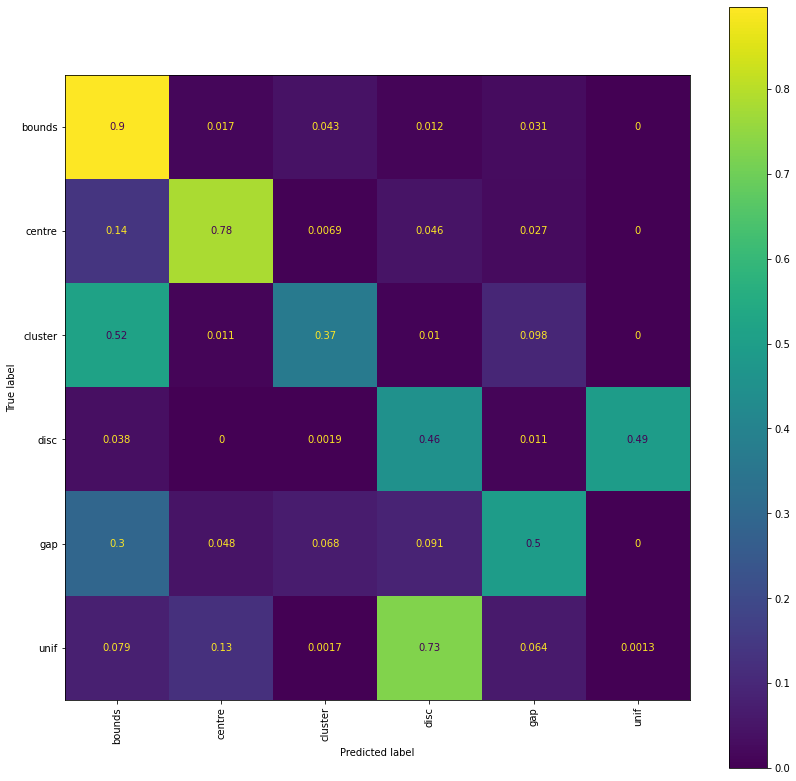

In [ ]:
model1 = newmodel(model)
fig, ax = plt.subplots(figsize=(14, 14))
plot_confusion_matrix(model1, X_test, np.argmax(y_test, axis=1), normalize='true', xticks_rotation = 'vertical', display_labels = list(np.unique(targetnames)), ax=ax) 
plt.show()

In [9]:
y_hat = model1.predict(X_test[:10])
print(y_hat)
print(y_test[:10])

[5 3 4 4 0 4 0 3 0 0]
[[0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0.]]
